<a href="https://colab.research.google.com/github/srirakshareddy/Semantic-analysis/blob/main/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
import tensorflow as tf
import keras
from keras.layers import Bidirectional, LSTM, GRU
from keras.models import Sequential
from keras.preprocessing import text
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


import nltk
import string
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize, TweetTokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


from keras import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Layer, Input, Embedding, Conv1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D, Flatten

import tensorflow.keras as keras
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.layers.experimental.preprocessing import Resizing



In [ ]:
df = pd.read_csv("data.csv" )
a=[0,5];
df=df.iloc[:,a]
df = df.sample(n = 10000)

In [ ]:
df.head()

,target,text
19319,0,shares http://tinyurl.com/cnlodg (me fanmade v...
53690,1,Dropping ashley off at the airport...I'm gonna...
67655,0,[Wrong!] @JoelMadden your proving to the world...
111144,0,I love the show 'Heroes'! Sooooo tough waiting...
10894,0,@malcolli who doesn't love fuzzy crits?


In [ ]:
def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove mentions (@username), all URLs, all hashtags.  
    text = re.sub("@\S+|http\S+|#\S+", "", text)
        #Removing <"text"> type of text 
    text = re.sub('<.*?>+','',text)
    
    #Removing punctuations
    text = re.sub("[%s]" % re.escape(string.punctuation),'',text)
    
    #Removing new lines
    text = re.sub("\n",'',text)
    
    #Removing alphanumeric numbers 
    text = re.sub('\w*\d\w*','',text)
    # Tokenize
    tokenized_text = word_tokenize(text)
    cleaned_tokens = [t for t in tokenized_text if t.isalnum()]
    cleaned_string = " ".join(cleaned_tokens)
    return cleaned_string

In [ ]:
def cleanDF(df):
    df["text"] = df["text"].apply(lambda x : preprocess(x))
    return df

In [ ]:
df = cleanDF(df)
df

,target,text
19319,0,shares me fanmade video
53690,1,dropping ashley off at the airportim gon na mi...
67655,0,wrong your proving to the world your a real ma...
111144,0,i love the show heroes sooooo tough waiting an...
10894,0,who doesnt love fuzzy crits
...,...,...
85464,0,hey miley cant wait to see u on jonathan ross ...
16313,1,back to work on monday after weeks off
111783,0,mornin lol i like your bio on twitter re the k...
58761,1,lol this edition of am idol didnt have that so...


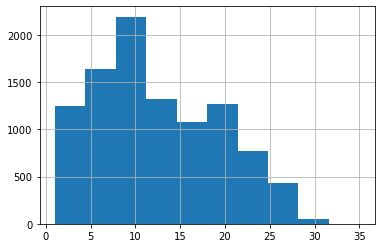

Mean: 12.3551
Std: 6.7947
Mean+3*Std = 32.7391


In [ ]:
lengths = df["text"].apply(lambda x : len(x.split(" "))) # mean + 3*sigma
lengths.hist()
plt.show()

mean = lengths.mean()
std = lengths.std()
approx_nseq = mean + 3*std
print(f"Mean: {mean:.4f}\nStd: {std:.4f}\nMean+3*Std = {approx_nseq:.4f}")

In [ ]:
N_SEQ = 256

In [ ]:
# Split into training and test sets
df_train, df_test = train_test_split(df, train_size = 0.7, shuffle = True, random_state = 42)

In [ ]:
df_test

,target,text
12445,0,i could do you some
59577,0,k sounds like some classic fuckery
37406,1,could really go some kfc
43113,1,work in the morning its so hot still
52318,1,isnt it so fun when a haircutter fcks up your ...
...,...,...
57165,0,i had a very productive day today pssssssh the...
58358,1,up early trying to get back into a routine aft...
82922,1,awe who were you ment to be going to town with...
38087,1,just a silly wee illness it has self resolved ...


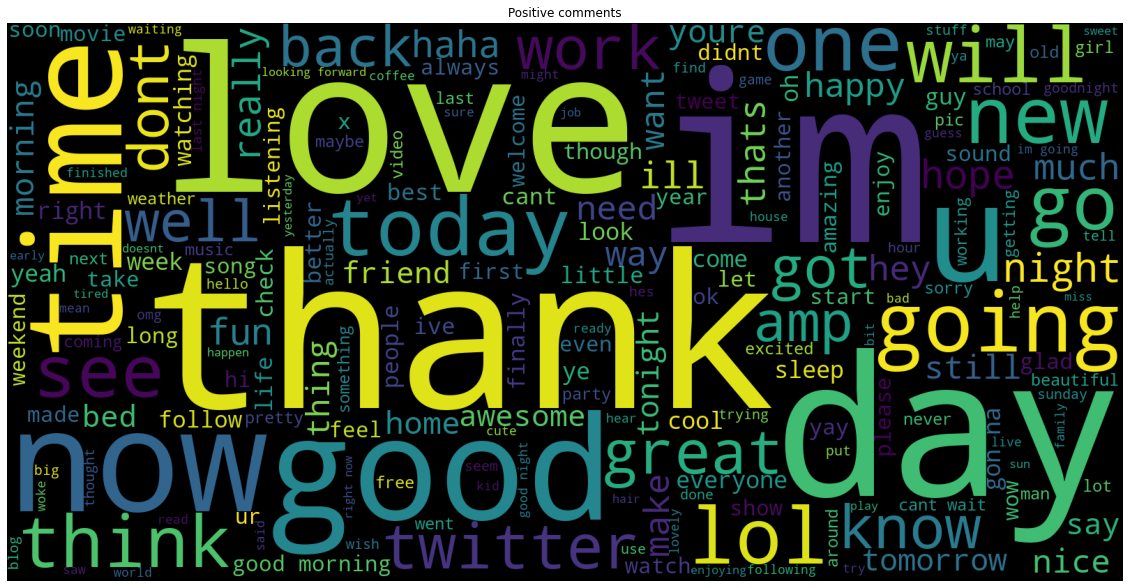

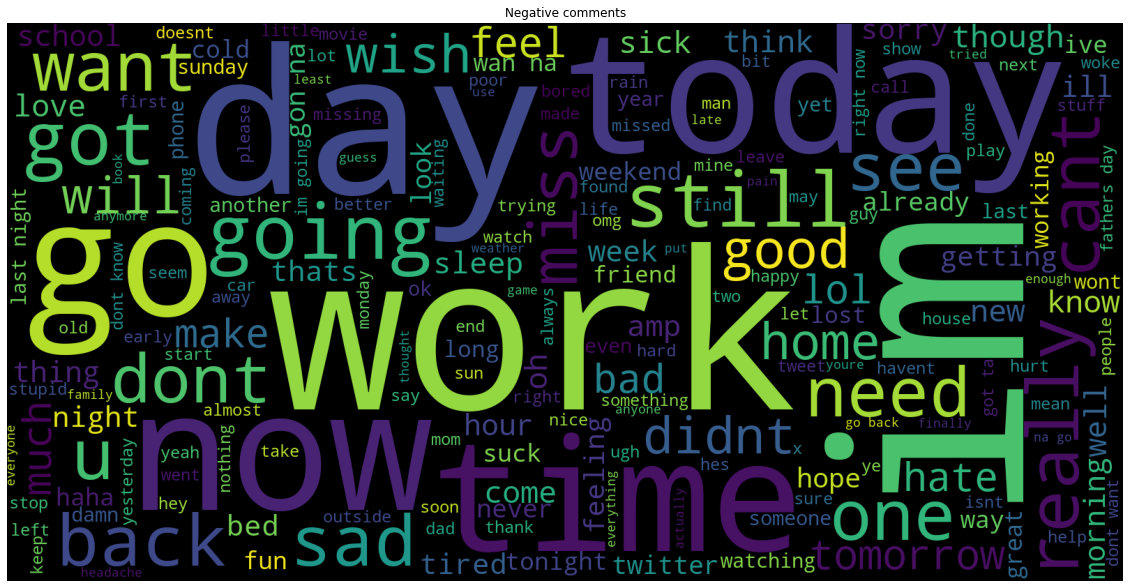

In [ ]:
from wordcloud import WordCloud

df_pos = df.loc[df["target"] == 0]
df_neg = df.loc[df["target"] == 1]

wc_pos = WordCloud(
    width = 1600, 
    height = 800, 
).generate(" ".join(df_pos["text"])) 

wc_neg = WordCloud(
    width = 1600, 
    height = 800, 
).generate(" ".join(df_neg["text"])) 

plt.figure(figsize = (20,20))
plt.imshow(wc_pos)
plt.title("Positive comments")
plt.axis("off")
plt.show()

plt.figure(figsize = (20,20))
plt.imshow(wc_neg)
plt.title("Negative comments")
plt.axis("off")
plt.show()

In [ ]:
t = Tokenizer()
t.fit_on_texts(df_train["text"])
word_index = t.word_index
N_vocab = len(t.word_index) + 1 # This +1 is used later 
print(N_vocab)

11193


In [ ]:
x_train = pad_sequences(t.texts_to_sequences(df_train["text"]), maxlen = N_SEQ)
x_test   = pad_sequences(t.texts_to_sequences(df_test["text"]), maxlen = N_SEQ)
y_train = df_train["target"].to_numpy(dtype = float).reshape(-1, 1)
y_test   = df_test["target"].to_numpy(dtype = float).reshape(-1, 1)

In [ ]:
# Maps each word in the embeddings vocabulary to it's embedded representation 
embeddings_index = {}
with open("glove.twitter.27B.200d.txt", "r", errors="ignore", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

In [ ]:
# Maps each word in our vocab to it's embedded representation, if the word is present in the GloVe embeddings
N_EMB = 200
embedding_matrix = np.zeros((N_vocab, N_EMB))
n_match = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        n_match += 1
        embedding_matrix[i] = embedding_vector
print(n_match)

9418


In [ ]:
# Dimensionality of the hidden state h_t outputted by the GRU
DIM_HIDDEN = 64 

In [ ]:
model=Sequential()
#model.add(Input(shape=(N_SEQ,)))
model.add(Embedding(N_vocab,N_EMB, weights = [embedding_matrix],input_length = N_SEQ, trainable = False ))
model.add(GRU(units=DIM_HIDDEN, dropout = 0.2, return_sequences = True))
model.add(Flatten())
#model.add(Input(shape = (N_SEQ*DIM_HIDDEN,)))
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))

In [ ]:
check3 = tf.keras.callbacks.ModelCheckpoint(filepath="weights3.h5",monitor="val_accuracy",mode="max",save_best_only=True,)
log3 = CSVLogger('log3.csv', append=True, separator=',')

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics = ["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 200)          2238600   
                                                                 
 gru (GRU)                   (None, 256, 64)           51072     
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 1024)              16778240  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [ ]:
history = model.fit(
    x_train, 
    y_train, 
    batch_size = 256, 
    epochs = 10,
    verbose=1,
    validation_data = (x_test, y_test), 
    callbacks=[check3,log3]
)

Epoch 1/10
28/28 [==============================] - 52s 2s/step - loss: 0.6793 - accuracy: 0.5651 - val_loss: 0.6176 - val_accuracy: 0.6650
Epoch 2/10
28/28 [==============================] - 48s 2s/step - loss: 0.5600 - accuracy: 0.7116 - val_loss: 0.5318 - val_accuracy: 0.7260
Epoch 3/10
28/28 [==============================] - 50s 2s/step - loss: 0.5039 - accuracy: 0.7544 - val_loss: 0.5162 - val_accuracy: 0.7323
Epoch 4/10
28/28 [==============================] - 49s 2s/step - loss: 0.4686 - accuracy: 0.7759 - val_loss: 0.5080 - val_accuracy: 0.7467
Epoch 5/10
28/28 [==============================] - 77s 3s/step - loss: 0.4313 - accuracy: 0.8019 - val_loss: 0.5121 - val_accuracy: 0.7520
Epoch 6/10
28/28 [==============================] - 50s 2s/step - loss: 0.3921 - accuracy: 0.8163 - val_loss: 0.5218 - val_accuracy: 0.7480
Epoch 7/10
28/28 [==============================] - 47s 2s/step - loss: 0.3626 - accuracy: 0.8327 - val_loss: 0.5789 - val_accuracy: 0.7367
Epoch 8/10
28/28 [==

In [ ]:
transfer_model = tf.keras.models.load_model('weights3.h5')

In [ ]:
transfer_model.evaluate(x_test, y_test,batch_size=256, verbose=1)

12/12 [==============================] - 5s 347ms/step - loss: 0.5121 - accuracy: 0.7520


[0.5120716691017151, 0.7519999742507935]

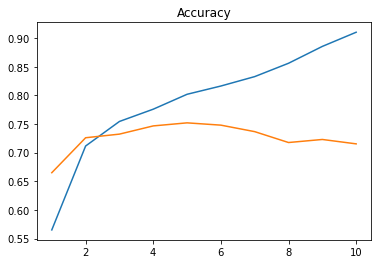

In [ ]:
N_EPOCHS=10
metrics = history.history
t_acc = metrics["accuracy"]
t_loss = metrics["loss"]
v_acc = metrics["val_accuracy"]
v_loss = metrics["val_loss"]

epochs = range(1, N_EPOCHS + 1)

plt.plot(epochs, t_acc)
plt.plot(epochs, v_acc)
plt.title("Accuracy")


plt.show()

In [ ]:
y_pred = []
for i in x_test:
    i = np.expand_dims(i, 0)
    y_pred.append(1 if model.predict(i) > 0.5 else 0)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report( y_pred,y_test))

              precision    recall  f1-score   support

           0       0.78      0.68      0.73      1664
           1       0.66      0.76      0.70      1336

    accuracy                           0.72      3000
   macro avg       0.72      0.72      0.71      3000
weighted avg       0.72      0.72      0.72      3000

